ワードクラウドで特許データを分析

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/patent5')

In [ ]:
!pip install spacy==3.4.4

In [ ]:
!pip install SudachiPy==0.5.4 ginza==4.0.6 ja-ginza==4.0.0 sklearn pandas

  Using cached SudachiPy-0.5.4.tar.gz (86 kB)
  Preparing metadata (setup.py) ... done
  Using cached ginza-4.0.6.tar.gz (20 kB)
  Preparing metadata (setup.py) ... done
  Using cached ja_ginza-4.0.0.tar.gz (51.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install -U ginza ja-ginza

ここでランタイムを再起動してください。

In [ ]:
import spacy
nlp = spacy.load("ja_ginza")

インストールしたライブラリ

In [ ]:
#! pip install -U ginza ja_ginza
! pip install wordcloud japanize-matplotlib
! pip install japanize-matplotlib
! wget -c https://moji.or.jp/wp-content/ipafont/IPAexfont/IPAexfont00401.zip
! mkdir -p fonts
! unzip -d fonts -o IPAexfont00401.zip
! rm -f IPAexfont00401.zip
from collections import Counter
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
import japanize_matplotlib
import numpy as np
#from google.colab import drive
#drive.mount('/content/drive')

--2024-02-02 04:58:44--  https://moji.or.jp/wp-content/ipafont/IPAexfont/IPAexfont00401.zip
Resolving moji.or.jp (moji.or.jp)... 157.7.44.215
Connecting to moji.or.jp (moji.or.jp)|157.7.44.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9738669 (9.3M) [application/zip]
Saving to: ‘IPAexfont00401.zip’

IPAexfont00401.zip  100%[===================>]   9.29M  8.41MB/s    in 1.1s    

2024-02-02 04:58:46 (8.41 MB/s) - ‘IPAexfont00401.zip’ saved [9738669/9738669]

Archive:  IPAexfont00401.zip
  inflating: fonts/IPAexfont00401/ipaexg.ttf  
  inflating: fonts/IPAexfont00401/ipaexm.ttf  
  inflating: fonts/IPAexfont00401/IPA_Font_License_Agreement_v1.0.txt  
  inflating: fonts/IPAexfont00401/Readme_IPAexfont00401.txt  


使用する品詞とストップワードを設定し、解析器を初期化します

In [ ]:
include_pos = ('NOUN', 'PROPN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう', 'いる', 'くる',  'できる', '部', 'ドローン', '前記', '複数', '備える', 'よる', '所定')
nlp = spacy.load("ja_ginza")

前処理
googleドライブからCSVデータ2件を読み込みます。なお、2件となったのはj-platpatでは1回のダウンロードで取得できる特許件数が500件の制限があるためです。面倒ですが、今回は494件と466件の2つのCSVファイルに分割してダウンロードします。2件のCSVデータを結合して1つのデータフレームにし、分析に必要な列（出願番号、出願日、出願人/権利者、要約）のみ抽出します。



In [ ]:
#df_drone_data = pd.read_csv("/content/drive/MyDrive/patent2/特実_国内文献.csv")
#df_drone_data_2 = pd.read_csv("/content/drive/MyDrive/pat_data_drone.20190101.csv", encoding = "shift-jis")
#df_drone_data = pd.concat([df_drone_data_1, df_drone_data_2], ignore_index = True)

# データの前処理
# データの読み込み(google ドライブから)
df_drone_data_0 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2016.csv")
df_drone_data_1 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2017.csv")
df_drone_data_2 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2018.csv")
df_drone_data_3 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2019.csv")
df_drone_data_4 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2020.csv")
df_drone_data_5 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2021.csv")
df_drone_data_6 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2022.csv")
df_drone_data_7 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2023.csv")
df_drone_data_8 = pd.read_csv("/content/drive/MyDrive/patent5/特実_国内文献2024.csv")

#df_drone_data_2 = pd.read_csv("/content/drive/MyDrive/pat_data_drone.20190101.csv", encoding = "shift-jis")
# データフレームの結合（縦方向）
df_drone_data = pd.concat([df_drone_data_0, df_drone_data_1, df_drone_data_2, df_drone_data_3, df_drone_data_4, df_drone_data_5, df_drone_data_6, df_drone_data_7, df_drone_data_8], ignore_index = True)

df_drone_data = df_drone_data[['出願番号', '出願日', '出願人/権利者', '要約']]

後で出願年の分析をするために、出願日の列を日付型に置き換えておきます。



In [ ]:
df_drone_data['出願日'] = pd.to_datetime(df_drone_data['出願日'])

分析対象の企業を絞り込むため、出願件数のtop10企業を図示します。企業ごとの出願件数のカウントにはCounterを使用しました。図表化にはmatplotlibを使用しました。



<BarContainer object of 10 artists>

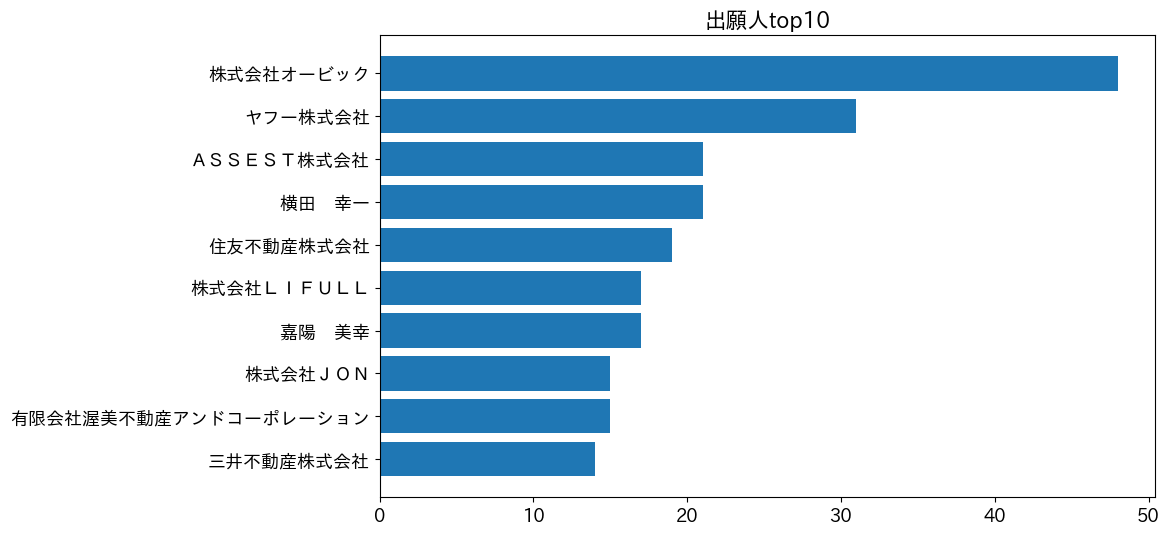

In [ ]:
df_drone_data['app'] = df_drone_data['出願人/権利者'].str.split(',')
app = sum(df_drone_data['app'], [])
counter = Counter(app)
df = pd.DataFrame(counter.most_common(10))
df = df.sort_values(by=1, ascending=True)
x = df[0]
y = df[1]
fig = plt.figure(figsize=(10.0,6.0))
fig = plt.rcParams["font.size"]=13
plt.title("出願人top10")
plt.barh(x,y)


In [ ]:
%matplotlib notebook

In [ ]:
df_drone_data['app'] = df_drone_data['出願人/権利者'].str.split(',')
app = sum(df_drone_data['app'], [])
counter = Counter(app)
df = pd.DataFrame(counter.most_common(10))
df = df.sort_values(by=1, ascending=True)
x = df[0]
y = df[1]
fig = plt.figure(figsize=(10.0,6.0))
fig = plt.rcParams["font.size"]=13
plt.title("出願人top10")
plt.barh(x,y)


<IPython.core.display.Javascript object>

<BarContainer object of 10 artists>

In [ ]:
plt.show()
plt.savefig('/content/drive/MyDrive/patent5/TOP10.png')

In [ ]:
plt.close()

top3社のデータフレームの作成

In [ ]:
df_drone_data

,出願番号,出願日,出願人/権利者,要約,app
0,特願2017-524528,2015-06-25,楽天株式会社,(57)【要約】\r\n サーバ装置（１００）は、受付部（１０１）と、取得<BR>部（１０...,[楽天株式会社]
1,実願2016-005048,2016-10-19,橋本不動産株式会社,(57)【要約】\r\n【課題】建設費の増大及び住宅設計の自由度の制限を抑<BR>えつつ、地...,[橋本不動産株式会社]
2,特願2015-110907,2015-05-29,"有限会社コンチェルト,株式会社ホームズ販売",(57)【要約】\r\n【課題】登記所における最新の登記情報に従った、検索<BR>対象の地番...,"[有限会社コンチェルト, 株式会社ホームズ販売]"
3,特願2016-148528,2016-07-28,レンプコ インダストリーズ インク,(57)【要約】 （修正有）\r\n【課題】動的なエクイティ金融商品を構築・実行す...,[レンプコ インダストリーズ インク]
4,特願2015-167254,2015-07-19,嘉陽 美幸,(57)【要約】 （修正有）\r\n【課題】個人にとってゆとりある旅行ができ、また...,[嘉陽 美幸]
...,...,...,...,...,...
862,特願2022-108180,2022-07-05,Ｓｅｃｕｒｉｔｉｚｅ２４合同会社,(57)【要約】\r\n【課題】ブロックチェーンを用いて不動産取引を記録す<BR>ると共に、...,[Ｓｅｃｕｒｉｔｉｚｅ２４合同会社]
863,特願2022-106351,2022-06-30,株式会社オービック,(57)【要約】\r\n【課題】新規の契約データのシミュレーションデータ作<BR>成を簡単か...,[株式会社オービック]
864,特願2020-195312,2020-11-25,"プロパー ピーティーイー リミテッド,株式会社Ｐｒｏｐｒｅ Ｊａｐａｎ",(57)【要約】 （修正有）\r\n【課題】顧客毎に異なるニーズで応え、より効果的...,"[プロパー ピーティーイー リミテッド, 株式会社Ｐｒｏｐｒｅ Ｊａｐａｎ]"
865,特願2023-072594,2023-04-26,株式会社ドッドウエルビー・エム・エス,(57)【要約】\r\n【課題】人手による鍵の受け渡しを不要とし、鍵の管理<BR>に係る経費...,[株式会社ドッドウエルビー・エム・エス]


In [ ]:
df_orb = df_drone_data.copy()
df_orb['出願人/権利者'] = df_orb['出願人/権利者'].str.contains('オービック')
df_orb = df_orb[~(df_orb['出願人/権利者'] == False)]

df_yah = df_drone_data.copy()
df_yah['出願人/権利者'] = df_yah['出願人/権利者'].str.contains('ヤフー株式会社')
df_yah = df_yah[~(df_yah['出願人/権利者'] == False)]

df_ass = df_drone_data.copy()
df_ass['出願人/権利者'] = df_ass['出願人/権利者'].str.contains('ＡＳＳＥＳＴ株式会社')
df_ass = df_ass[~(df_ass['出願人/権利者'] == False)]

df_yok = df_drone_data.copy()
df_yok['出願人/権利者'] = df_yok['出願人/権利者'].str.contains('横田')
df_yok = df_yok[~(df_yok['出願人/権利者'] == False)]

df_sum = df_drone_data.copy()
df_sum['出願人/権利者'] = df_sum['出願人/権利者'].str.contains('住友不動産')
df_sum = df_sum[~(df_sum['出願人/権利者'] == False)]

df_lif = df_drone_data.copy()
df_lif['出願人/権利者'] = df_lif['出願人/権利者'].str.contains('ＬＩＦＵＬＬ')
df_lif = df_lif[~(df_lif['出願人/権利者'] == False)]

top3社の出願件数推移の確認

In [ ]:
df_orb

,出願番号,出願日,出願人/権利者,要約,app
33,特願2015-215830,2015-11-02,True,(57)【要約】\r\n【課題】「ビルのオーナー会社とテナントとの間に管理<BR>会社が存在...,[株式会社オービック]
38,特願2015-215745,2015-11-02,True,(57)【要約】\r\n【課題】分譲マンションの所有者の入替が発生した際に<BR>管理組合が...,[株式会社オービック]
81,特願2017-065516,2017-03-29,True,(57)【要約】\r\n【課題】一度の処理で国内基準とＩＦＲＳ基準の処理が<BR>できるよう...,[株式会社オービック]
250,特願2018-060003,2018-03-27,True,(57)【要約】\r\n【課題】賃料管理の送金を行う場合の業務負担及び事務<BR>過誤を低減...,[株式会社オービック]
290,特願2017-223624,2017-11-21,True,(57)【要約】\r\n【課題】複数に区分可能な不動産の原価を計算する際に<BR>、引渡済み...,[株式会社オービック]
298,特願2017-189757,2017-09-29,True,(57)【要約】 （修正有）\r\n【課題】金融機関が不動産を評価する際に、有効担...,[株式会社オービック]
353,特願2019-064506,2019-03-28,True,(57)【要約】\r\n【課題】不動産などの管理委託契約に対する所有者の変<BR>更に係る処...,[株式会社オービック]
364,特願2019-039985,2019-03-05,True,(57)【要約】 （修正有）\r\n【課題】評価対象の不動産の収益属性に応じて収益...,[株式会社オービック]
368,特願2019-020076,2019-02-06,True,(57)【要約】\r\n【課題】他のオーナーと自社で所有している信託受益物<BR>件について...,[株式会社オービック]
370,特願2019-017413,2019-02-01,True,(57)【要約】 （修正有）\r\n【課題】相続税上の財産評価において、非上場の自...,[株式会社オービック]


In [ ]:
plt.close()

In [ ]:
df_y_orb = df_orb['出願日'].dt.year.value_counts().sort_index().reset_index()
df_y_orb.columns = ["出願年", "件数"]
x_orb = df_y_orb["出願年"]
y_orb = df_y_orb["件数"]

df_y_yah = df_yah['出願日'].dt.year.value_counts().sort_index().reset_index()
df_y_yah.columns = ["出願年", "件数"]
x_yah = df_y_yah["出願年"]
y_yah = df_y_yah["件数"]

df_y_ass = df_ass['出願日'].dt.year.value_counts().sort_index().reset_index()
df_y_ass.columns = ["出願年", "件数"]
x_ass = df_y_ass["出願年"]
y_ass = df_y_ass["件数"]

df_y_yok = df_yok['出願日'].dt.year.value_counts().sort_index().reset_index()
df_y_yok.columns = ["出願年", "件数"]
x_yok = df_y_yok["出願年"]
y_yok = df_y_yok["件数"]


df_y_sum = df_sum['出願日'].dt.year.value_counts().sort_index().reset_index()
df_y_sum.columns = ["出願年", "件数"]
x_sum = df_y_sum["出願年"]
y_sum = df_y_sum["件数"]


df_y_lif = df_lif['出願日'].dt.year.value_counts().sort_index().reset_index()
df_y_lif.columns = ["出願年", "件数"]
x_lif = df_y_lif["出願年"]
y_lif = df_y_lif["件数"]

fig = plt.figure(figsize=(10,6))
fig = plt.rcParams["font.size"]=13
plt.title("出願件数推移（2016～2023）")
plt.xticks(np.arange(2015, 2024, 1))
plt.xlim(2015, 2023)
plt.ylim(0,18,2)
plt.plot(x_orb,y_orb, label='オービック')
plt.plot(x_yah,y_yah, label='ヤフー')
plt.plot(x_ass,y_ass, label='ＡＳＳＥＳＴ')
plt.plot(x_yok,y_yok, label='横田幸一')
plt.plot(x_sum,y_sum, label='住友不動産')
plt.plot(x_lif,y_lif, label='ＬＩＦＵＬＬ')

plt.xlabel('出願年')
plt.ylabel('出願件数')
plt.legend()

<IPython.core.display.Javascript object>

<ipython-input-17-0cfb64124087>:38: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0,18,2)


In [ ]:
plt.show()
plt.savefig('/content/drive/MyDrive/patent5/time.png')

ワードクラウドの作成

次に、ナイルワークス、NTTドコモ、トヨタ自動車の要約の記載からワードクラウドを作成します。形態素解析にはspaCyを使用し、ワードクラウドの作成には、WordCloudを使用します。

In [ ]:
#include_pos = ('NOUN', 'PROPN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう', 'いる', 'くる', 'できる', '部','前記', '複数', '備える', 'よる', '所定','br','関する','基づく','以上','上記','設ける','図','場','要約','選択','課題','応ずる','有する','対する','d')
nlp = spacy.load("ja_ginza")



In [ ]:
# オービックorb
words_orb = []
for doc_orb in nlp.pipe(df_orb['要約']):
  words_orb.extend([token.lemma_ for token in doc_orb
    if token.pos_ in include_pos and token.lemma_ not in stopwords])
wc_orb = wordcloud.WordCloud(background_color='white', font_path='fonts/IPAexfont00401/ipaexg.ttf', max_font_size=100).generate(' '.join(words_orb))
plt.figure(figsize=(8, 4))
plt.imshow(wc_orb, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("オービック" )

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'オービック')

In [ ]:
plt.show()
plt.savefig('/content/drive/MyDrive/patent5/orb.png')

In [ ]:
# ヤフー　yah
words_yah = []
for doc_yah in nlp.pipe(df_yah['要約']):
  words_yah.extend([token.lemma_ for token in doc_yah
    if token.pos_ in include_pos and token.lemma_ not in stopwords])
wc_yah = wordcloud.WordCloud(background_color='white', font_path='fonts/IPAexfont00401/ipaexg.ttf', max_font_size=100).generate(' '.join(words_yah))
plt.figure(figsize=(8, 4))
plt.imshow(wc_yah, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("ヤフー" )

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'ヤフー')

In [ ]:
plt.show()
plt.savefig('/content/drive/MyDrive/patent5/yah.png')

In [ ]:
# ＡＳＳＥＳＴ ass
words_ass = []
for doc_ass in nlp.pipe(df_ass['要約']):
  words_ass.extend([token.lemma_ for token in doc_ass
    if token.pos_ in include_pos and token.lemma_ not in stopwords])
wc_ass = wordcloud.WordCloud(background_color='white', font_path='fonts/IPAexfont00401/ipaexg.ttf', max_font_size=100).generate(' '.join(words_ass))
plt.figure(figsize=(8, 4))
plt.imshow(wc_ass, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("ASSEST" )

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'ASSEST')

In [ ]:
plt.show()
plt.savefig('/content/drive/MyDrive/patent5/ass.png')

In [ ]:
# 横田幸一 yok
words_yok = []
for doc_yok in nlp.pipe(df_yok['要約']):
  words_yok.extend([token.lemma_ for token in doc_yok
    if token.pos_ in include_pos and token.lemma_ not in stopwords])
wc_yok = wordcloud.WordCloud(background_color='white', font_path='fonts/IPAexfont00401/ipaexg.ttf', max_font_size=100).generate(' '.join(words_yok))
plt.figure(figsize=(8, 4))
plt.imshow(wc_yok, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("横田幸一" )

<IPython.core.display.Javascript object>

Text(0.5, 1.0, '横田幸一')

In [ ]:
plt.show()
plt.savefig('/content/drive/MyDrive/patent5/yok.png')

In [ ]:
# 住友不動産 sum
words_sum = []
for doc_sum in nlp.pipe(df_sum['要約']):
  words_sum.extend([token.lemma_ for token in doc_sum
    if token.pos_ in include_pos and token.lemma_ not in stopwords])
wc_sum = wordcloud.WordCloud(background_color='white', font_path='fonts/IPAexfont00401/ipaexg.ttf', max_font_size=100).generate(' '.join(words_sum))
plt.figure(figsize=(8, 4))
plt.imshow(wc_sum, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("住友不動産" )

<IPython.core.display.Javascript object>

Text(0.5, 1.0, '住友不動産')

In [ ]:
plt.show()
plt.savefig('/content/drive/MyDrive/patent5/sum.png')

In [ ]:
# LIFULL lif
words_lif = []
for doc_lif in nlp.pipe(df_lif['要約']):
  words_sum.extend([token.lemma_ for token in doc_lif
    if token.pos_ in include_pos and token.lemma_ not in stopwords])
wc_lif = wordcloud.WordCloud(background_color='white', font_path='fonts/IPAexfont00401/ipaexg.ttf', max_font_size=100).generate(' '.join(words_lif))
plt.figure(figsize=(8, 4))
plt.imshow(wc_lif, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("LIFULL" )

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
plt.show()
plt.savefig('/content/drive/MyDrive/patent5/lif.png')